# Building Deep Neural Network using just NumPy

Building a Neural Network classifier from **first principles**: 
* Create model architecture and initialize parameters
* Calculating Cost Function and its Gradients
* Optimizing using gradient descent

---
## Neural Network architecture

**Big Picture:**
<img src="images/final outline.png" style="width:800px;height:500px;">

**Cost:**
$$J = - \frac{1}{m} \sum\limits_{i = 1}^{m} \large{(} \small y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L] (i)}\right) \large{)} \small$$

**Forward-propagation:**
$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}$$
where $$A^{[0]} = X$$ 

**Back-propagation:**
<img src="images/backprop_kiank.png" style="width:650px;height:250px;">

$$ dW^{[l]} = \frac{\partial \mathcal{J} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T}$$
$$ db^{[l]} = \frac{\partial \mathcal{J} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]}$$
$$dZ^{[l]} = dA^{[l]} * g'(Z^{[l]})$$  

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
%matplotlib inline

---
## Loading data
* a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
* a test set of m_test images labeled as cat or non-cat
* each image is of shape (64, 64, 3) where 3 is for the 3 channels (RGB)

In [2]:
train = h5py.File('data/train_catvnoncat.h5', "r")
X_train_orig = np.array(train["train_set_x"][:])
Y_train = np.array(train["train_set_y"][:])

test = h5py.File('data/test_catvnoncat.h5', "r")
X_test_orig = np.array(test["test_set_x"][:]) 
Y_test = np.array(test["test_set_y"][:])
classes = np.array(test["list_classes"][:])

Y_train = Y_train.reshape((1, Y_train.shape[0]))
Y_test  = Y_test.reshape((1, Y_test.shape[0]))

X_train = X_train_orig.reshape(X_train_orig.shape[0],-1).T
X_test  = X_test_orig.reshape(X_test_orig.shape[0],-1).T

X_train = X_train / 255.
X_test = X_test / 255.

print ("X_train shape: " + str(X_train.shape))
print ("X_test shape: " + str(X_test.shape))

X_train shape: (12288, 209)
X_test shape: (12288, 50)


y = [0], it's a 'non-cat' picture.


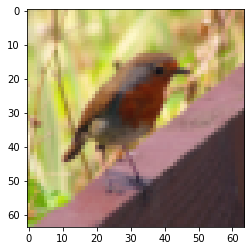

In [3]:
# Example of a picture
index = 10
plt.imshow(X_train_orig[index])
print ("y = " + str(Y_train[:, index]) + ", it's a '" + classes[np.squeeze(Y_train[:, index])].decode("utf-8") +  "' picture.")

## Helper Functions
---

### Initialize Parameters

In [4]:
def initialize_parameters(layer_dims):
    np.random.seed(1)
    params = {}
    L = len(layer_dims)
    
    # skip input/ layer 0. Uses Xavier initialization
    for i in range(1,L):
        params["W" + str(i)] = np.random.randn(layer_dims[i], layer_dims[i-1]) / np.sqrt(layer_dims[i-1])#* 0.01
        params["b" + str(i)] = np.zeros((layer_dims[i], 1))
    
    return params

### Forward Propagation

In [5]:
def linear_activation_forward(A_prev, W, b, activation='relu'):
    """ Compute forward propagation across one layer """
    
    Z = np.dot(W, A_prev) + b
    
    if activation == "sigmoid":    
        A = 1/(1+np.exp(-Z))
    elif activation == "relu":
        A = np.maximum(0, Z)
    
    cache_in  = (A_prev, W, b)   # Note the definition, cache_in = inputs
    cache = (cache_in, Z)        # Note the definition, cache = inputs + output

    return A, cache

In [6]:
def forward_propagation(X, parameters):
    """ Compute forward propagation across layers """
    
    caches = []
    A = X
    L = len(parameters) // 2 # number of layers in the neural network
    
    # Layers: 1, 2, .. L-1
    for l in range(1, L):  
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W'+str(l)], parameters['b'+str(l)], 'relu')
        caches.append(cache)
            
    # Final layer
    AL, cache = linear_activation_forward(A, parameters['W'+str(L)], parameters['b'+str(L)], 'sigmoid') 
    
    # ((A_prev, W, b), Z)
    caches.append(cache)
          
    return AL, caches

### Cost

In [7]:
def compute_cost(AL, Y):
    """ Computes the cross-entropy cost """
    
    m = Y.shape[1]   # number of examples
    cost = (-1/m)*(np.dot(np.log(AL), Y.T) + np.dot(np.log(1-AL), (1-Y).T))    
    cost = float(np.squeeze(cost))
    return cost

### Backward Propagation

In [8]:
def linear_activation_backward(dA, cache, activation):
    """ Compute backward propagation across one layer """

    (A_prev, W, b), Z = cache
    
    # Calculate dZ
    if activation == "relu":
        dZ = np.array(dA, copy=True)
        dZ[Z <= 0] = 0
        
    elif activation == "sigmoid":
        s = 1/(1+np.exp(-Z))
        dZ = dA * s * (1-s)
    
    # Gradients
    m = A_prev.shape[1]
    dW = (1/m)*np.dot(dZ, A_prev.T)
    db = (1/m)*np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
        
    return dA_prev, dW, db

In [9]:
def backward_propagation(AL, Y, caches):
    """ Compute backward propagation across across layer """
    
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # Y is the same shape as AL
    
    # Last layer
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Lth layer (SIGMOID -> LINEAR) gradients
    current_cache = caches[L-1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, 'sigmoid')
    grads["dA" + str(L-1)] = dA_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dA_prev_temp, current_cache, 'relu')
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l+1)] = dW_temp
        grads["db" + str(l+1)] = db_temp
        
    return grads

### Update Parameters

In [10]:
def update_parameters(parameters, grads, learning_rate=0.01):
    """
    Updates parameters using the gradient descent
    """
    params = parameters.copy()
    L = len(params) // 2 # number of layers in the neural network

    for l in range(L):
        params["W" + str(l+1)] = params["W" + str(l+1)] - learning_rate*grads['dW'+str(l+1)]
        params["b" + str(l+1)] = params["b" + str(l+1)] - learning_rate*grads['db'+str(l+1)]
    
    return params

### Predict

In [11]:
def predict(parameters, X):
    AL, _ = forward_propagation(X, parameters)
    predictions = np.round(AL)
    return predictions

### Combining into an Overall Model

In [12]:
def multi_layer_model(X_train, Y_train, X_test, Y_test, layer_dims, 
                      num_iterations = 3000, print_cost=True, learning_rate=0.001):
    """
    Structure:
    - initialize parameters using Xavier initialization
    - Iterate over {forward propagation / AL, cost, backward propagation/ gradients, update parameters}
    """
    np.random.seed(3)
    costs = []
    parameters = initialize_parameters(layers_dims)
    
    for i in range(0, num_iterations):
        AL, caches = forward_propagation(X_train, parameters)             # Forward pass to get AL and caches
        cost = compute_cost(AL, Y_train)                                  # Compute cost
        grads = backward_propagation(AL, Y_train, caches)                 # Backward pass to get gradients
        parameters = update_parameters(parameters, grads, learning_rate)  # Update params
        
        if print_cost and (i % 100 == 0 or i == num_iterations-1):
            print ('Cost after iteration {}: {:.4f}'.format(i, cost))
            costs.append(cost)

    # Make Predictions
    Y_pred_train = predict(parameters, X_train)
    Y_pred_test = predict(parameters, X_test)
    
    # Print train/test fit
    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_pred_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_pred_test - Y_test)) * 100))
    
    # Save model output
    d = {"costs": costs,
         "Y_pred_train": Y_pred_train, 
         "Y_pred_test" : Y_pred_test, 
         "parameters" : parameters,
         "learning_rate" : learning_rate}
    
    return d

---
## Running Model

In [13]:
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model + input layer

model = multi_layer_model(X_train, Y_train, X_test, Y_test, layers_dims, num_iterations = 3000, print_cost=True, learning_rate=0.0075)

Cost after iteration 0: 0.7717
Cost after iteration 100: 0.6721
Cost after iteration 200: 0.6483
Cost after iteration 300: 0.6115
Cost after iteration 400: 0.5670
Cost after iteration 500: 0.5401
Cost after iteration 600: 0.5279
Cost after iteration 700: 0.4655
Cost after iteration 800: 0.3691
Cost after iteration 900: 0.3917
Cost after iteration 1000: 0.3152
Cost after iteration 1100: 0.2727
Cost after iteration 1200: 0.2374
Cost after iteration 1300: 0.1996
Cost after iteration 1400: 0.1893
Cost after iteration 1500: 0.1612
Cost after iteration 1600: 0.1482
Cost after iteration 1700: 0.1378
Cost after iteration 1800: 0.1297
Cost after iteration 1900: 0.1212
Cost after iteration 2000: 0.1138
Cost after iteration 2100: 0.1078
Cost after iteration 2200: 0.1029
Cost after iteration 2300: 0.1009
Cost after iteration 2400: 0.0929
Cost after iteration 2500: 0.0884
Cost after iteration 2600: 0.0860
Cost after iteration 2700: 0.0817
Cost after iteration 2800: 0.0782
Cost after iteration 2900:

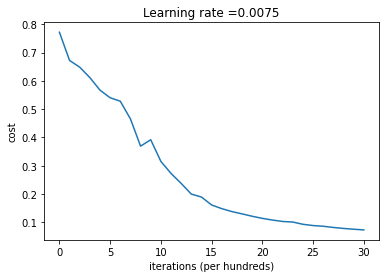

In [14]:
# Plot learning curve (with costs)
costs = np.squeeze(model['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(model["learning_rate"]))
plt.show()

## Conclusion
Multi-layer Neural Network learns performs better (Test accuracy of 82%) than simpler 2-layer network.

### Sample Outputs

y = 1, prediction is "cat" picture.


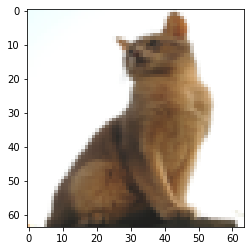

In [15]:
# This example is now correctly classied (vs. simpler neural network)
index = 6
plt.imshow(X_test[:, index].reshape((64,64,3)))
print ("y = " + str(Y_test[0,index]) + ", prediction is \"" + classes[int(model['Y_pred_test'][0,index])].decode("utf-8") +  "\" picture.")

In [16]:
print('Train predictions', np.unique(model['Y_pred_train'], return_counts=True))
print('Test predctions', np.unique(model['Y_pred_test'], return_counts=True))

Train predictions (array([0., 1.]), array([139,  70], dtype=int64))
Test predctions (array([0., 1.]), array([12, 38], dtype=int64))


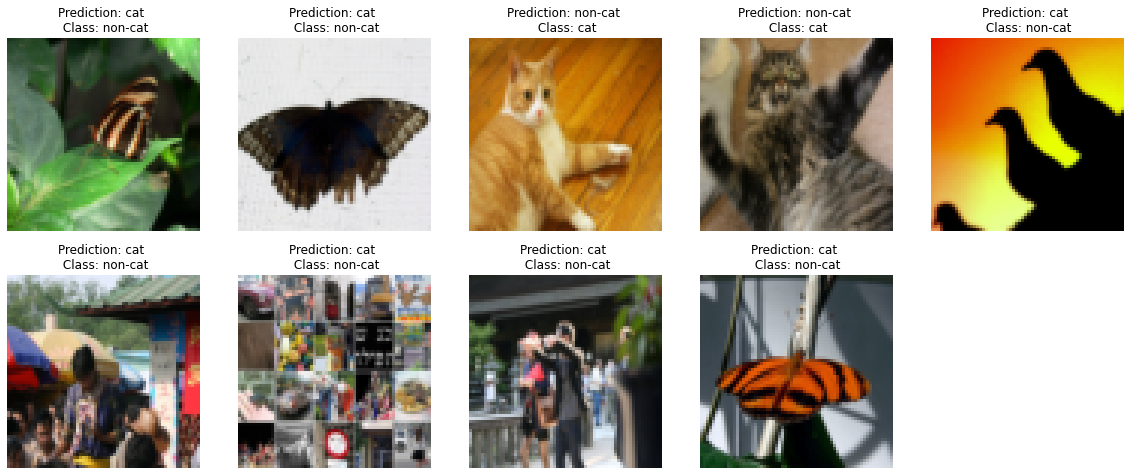

In [17]:
# Misclassified examples

preds = model['Y_pred_test']
mislabeled_indices = np.where(np.squeeze(preds + Y_test == 1))[0]
plt.figure(figsize = (20, 8))

for i, ix in enumerate(mislabeled_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[:,ix].reshape(64,64,3), interpolation='nearest')
    plt.axis('off')
    plt.title("Prediction: " + classes[int(preds[0,ix])].decode("utf-8") + " \n Class: " + classes[Y_test[0,ix]].decode("utf-8"))
